### **Tensorflow-GPU cehck**

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.get_logger().setLevel('INFO')
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
tf.sysconfig.get_build_info()

2022-01-18 10:47:48.087298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-18 10:47:49.801610: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


OrderedDict([('cpu_compiler',
              '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614534878484/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'),
             ('cuda_compute_capabilities',
              ['compute_35',
               'compute_52',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75']),
             ('cuda_version', '10.1'),
             ('cudnn_version', '7'),
             ('is_cuda_build', True),
             ('is_rocm_build', False)])

2022-01-18 10:47:49.802755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-18 10:47:49.867289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-18 10:47:49.867331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-18 10:47:49.869598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-18 10:47:49.869637: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-01-18 10:47:49.871252: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.

## **Module**

In [2]:
import os
import re
import gc
import pickle
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
from matplotlib import rcParams

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

# rpy2
os.environ['R_HOME'] = '/home/km/anaconda3/envs/multiomics/lib/R' # env R invoke
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

#!python -m rpy2.situation

### **File Path**

In [5]:
CANCER_TYPE = "LIHC"
FILE_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
RAW_file_path = "/home/km/gitworking/Multi-omics-intergration/RAW_DATA/"
PKL_file_path = "/home/km/gitworking/Multi-omics-intergration/pkl/"
MODEL_PATH = "/home/km/gitworking/Multi-omics-intergration/models/"
TENSORBOARD_PATH = '/home/km/gitworking/Multi-omics-intergration/log'
GROUP_PHTH = '/home/km/gitworking/Multi-omics-intergration/group/'
PNG_PATH = '/home/km/gitworking/Multi-omics-intergration/png/'
print(FILE_NAME)

20220118-104813


## **UDF**

In [183]:
def cancer_select(cols, cancer_type):
    # phenotype
    phe1 = pd.read_csv("https://gdc-hub.s3.us-east-1.amazonaws.com/download/GDC-PANCAN.basic_phenotype.tsv.gz", sep="\t")
    phe1 = phe1.loc[phe1.program == "TCGA", :].loc[:, ['sample', 'sample_type', 'project_id']].drop_duplicates(['sample'])
    phe1['sample'] =  phe1.apply(lambda x : x['sample'][:-1], axis=1)
    phe2 = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz", sep="\t")
    ph_join = pd.merge(left = phe2 , right = phe1, how = "left", on = "sample").dropna(subset=['project_id'])
    
    if cancer_type == "PAN" or cancer_type == "PANCAN":
        filterd = ph_join.loc[ph_join['sample_type_y'] == "Primary Tumor", :]
        sample_barcode = filterd["sample"].tolist()
    else:
        filterd = ph_join.loc[(ph_join['sample_type_y'] == "Primary Tumor") & (ph_join['project_id'] == "TCGA-" + cancer_type) , :]
        sample_barcode = filterd["sample"].tolist()
        
    intersect_ = list(set(cols).intersection(sample_barcode))
    
    return intersect_

def non_zero_column(DF):
    sample_cnt = int(len(DF.columns) * 0.2)
    zero_row = dict(DF.isin([0]).sum(axis=1))
    non_remove_feature = list()

    for key, value in zero_row.items():
        if value < sample_cnt:
            non_remove_feature.append(key)
    
    return non_remove_feature

def load_tcga_dataset(pkl_path, raw_path, cancer_type, norm):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")

        # sep
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
    else :
        # RNA gene expression
        col = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)
        df_chunk = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        rna = pd.concat([chunk for chunk in df_chunk])
        rna = rna[rna.index.isin(non_zero_column(rna))].T
        
        rna.to_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")

        # miRNA expression
        col = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mirna = pd.concat([chunk for chunk in df_chunk])
        mirna = mirna[mirna.index.isin(non_zero_column(mirna))].T
        
        mirna.to_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")

        # methylation
        col = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mt = pd.concat([chunk for chunk in df_chunk])

        mt_map = pd.read_csv(raw_path + "probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy", sep="\t")

        mt_join = pd.merge(mt, mt_map, how = "left", left_on = "sample", right_on = "#id")\
                 .drop(['chrom', 'chromStart', 'chromEnd', 'strand', '#id'], axis=1)
        mt_join = mt_join[mt_join.gene != "."]
        mt_join.dropna(subset = ["gene"], inplace=True)

        # gene mean 
        mt_join_gene_filter = mt_join.groupby(['gene']).mean()
        mt_join_gene_filter = mt_join_gene_filter[mt_join_gene_filter.index.isin(non_zero_column(mt_join_gene_filter))].T
        
        mt_join_gene_filter.to_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt_join_gene_filter.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
        # set same column for merge
        rna['sample'] = rna.index
        mirna['sample'] = mirna.index
        mt_join_gene_filter['sample'] = mt_join_gene_filter.index

        # data join
        merge_list = [rna, mirna, mt_join_gene_filter]
        omics = reduce(lambda left, right : pd.merge(left, right, on = "sample"), merge_list)
        omics.set_index('sample', inplace=True)

        # pickle save
        omics.to_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
    
    # set index
    omics_index = omics.index.to_list()
    
    # normalization
    if norm:
        scalerX = StandardScaler()
        omics_scale = scalerX.fit_transform(omics)
    
    # missing impute
    imputer = KNNImputer(n_neighbors=10)
    omics_impute = imputer.fit_transform(omics_scale)

    omics = pd.DataFrame(omics_impute, columns=omics.columns)
    omics.index = omics_index

    return omics

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name) 
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
    return os.path.join(root_logdir, sub_dir_name)

# autoencoder
def run_ae(X_train, X_test, model_path, tensorboard_path, cancer_type, file_name):
    tf.keras.backend.clear_session()
    
    # encoder - decoder
    inputs_dim = X_train.shape[1]
    encoder = Input(shape = (inputs_dim, ))
    e = Dense(1000, activation = "relu")(encoder)
    # e = Dense(256, activation = "relu")(e)
    e = Dense(500, activation = "relu")(e)

    ## bottleneck layer
    n_bottleneck = 100

    ## defining it with a name to extract it later
    bottleneck_layer = "bottleneck_layer"

    # can also be defined with an activation function, relu for instance
    bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)

    ## define the decoder (in reverse)
    decoder = Dense(500, activation = "relu")(bottleneck)
    # decoder = Dense(256, activation = "relu")(decoder)
    decoder = Dense(1000, activation = "relu")(decoder)

    ## output layer
    output = Dense(inputs_dim)(decoder)

    ## end-to-end model
    model = Model(inputs = encoder, outputs = output)
    
    # encdoer mdoel
    encoder = Model(inputs = model.input, outputs = bottleneck)
    
    # callback function
    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    TB_log_dir = make_Tensorboard_dir(tensorboard_path)
    TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

    # compile & fit
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    history = model.fit(
        X_train,
        X_train,
        batch_size = 128,
        epochs = 30,
        verbose = 0,
        validation_data = (X_test, X_test),
        callbacks=[TensorB]
    ) 
    model.save(model_path + "AE_" + cancer_type + "_" + file_name)
    
    return encoder

# invoke r
def log_test(df):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)

    # R UDF invoke
    r = ro.r
    r['source']('r-function.R')
    log_rank_test_r = ro.globalenv['log_rank_test']
    log_rank_test_feature = log_rank_test_r(r_from_pd_df)

    # R DF to pandas DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        log_rank_test = ro.conversion.rpy2py(log_rank_test_feature)

    feature_log = log_rank_test['Features'].to_list()
    
    return feature_log

def log_rank_test(df, png_path, file_name):
    group_size = len(set(df.loc[:, ["group"]].iloc[:,0].to_list()))
    labels = ["G" + str(index) for index in range(group_size)]
    
    groups = df.dropna().iloc[:, 0].to_list()
    events = df.dropna().iloc[:, 1].to_list()
    times = df.dropna().iloc[:, 2].to_list()

    E = np.array(events, dtype=np.int32)
    T = np.array(times, dtype=np.float32)
    
    #### 3. matplotlib parameter
    rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(5,5))
    styles = ['-', '--']
    colors = ['r', 'g']
    lw = 3

    #### 4. Kaplan-Meier 
    kmf = KaplanMeierFitter()
    for i, label in enumerate(labels):
        ix = np.array(groups) == i
        kmf.fit(T[ix], event_observed=E[ix], label=labels[i])
        kmf.plot(ax=ax, ci_show=False, linewidth=lw, style=styles[i], c=colors[i])

    #### 5. Logrank test
    ix = np.array(groups) == 1
    result = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)
    pvalue = result.p_value
    ax.text(50,0.3,'P-value=%.3f'% pvalue) # 위치(3.4,0.75) 수동으로 지정필요

    #### 6. 
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Survival', fontsize=14)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(png_path + file_name + "_logrank.png", format='png', dpi=300)
#     plt.show()

    return pvalue

# invoke r
def nb_cluster(df):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        omic_encoded_fc_r = ro.conversion.py2rpy(df)

    r = ro.r
    r['source']('r-function.R')
    nb_cluster_test = ro.globalenv['nb_cluster_test']
    nb_cluster_test_feature = nb_cluster_test(omic_encoded_fc_r)

    # R DF to pandas DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        omic_encoded_fc_r = ro.conversion.rpy2py(nb_cluster_test_feature)
        
    return omic_encoded_fc_r

# invoke r
def survfit(df, file_name, PNG_PATH):
    # pandas DF to R DF
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)

    # R UDF invoke
    r = ro.r
    r['source']('r-function.R')
    km_survival_r = ro.globalenv['km_survival']
    km_survival_r(r_from_pd_df, file_name, PNG_PATH)
    
## For Target
def load_preprocess_tcga_dataset(pkl_path, raw_path, group_path, cancer_type, norm):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        # sep
        omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt_join_gene_filter = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
    else :
        raise Exception("omics's pkl not exist!")
        
    # set column for unique
    omics.columns = list(map(lambda col : col + "_OMICS", omics.columns.to_list()))
    rna.columns = list(map(lambda col : col + "_RNA", rna.columns.to_list()))
    mirna.columns = list(map(lambda col : col + "_miRNA", mirna.columns.to_list()))
    mt_join_gene_filter.columns = list(map(lambda col : col + "_Methylation", mt_join_gene_filter.columns.to_list()))
        
    # set index
    omics_index = omics.index.to_list()
    rna_index = rna.index.to_list()
    mirna_index = mirna.index.to_list()
    mt_join_gene_filter_index = mt_join_gene_filter.index.to_list()
    
    # normalization
    if norm:
        scalerX = StandardScaler()
        omics_scale = scalerX.fit_transform(omics)
        rna_scale = scalerX.fit_transform(rna)
        mirna_scale = scalerX.fit_transform(mirna)
        mt_join_gene_filter_scale = scalerX.fit_transform(mt_join_gene_filter)

        # missing impute
        imputer = KNNImputer(n_neighbors=10)
        omics_impute = imputer.fit_transform(omics_scale)        
        rna_impute = imputer.fit_transform(rna_scale)
        mirna_impute = imputer.fit_transform(mirna_scale)
        mt_join_gene_filter_impute = imputer.fit_transform(mt_join_gene_filter_scale)

        # Pandas
        omics = pd.DataFrame(omics_impute, columns=omics.columns)
        omics.index = omics_index       
        
        rna = pd.DataFrame(rna_impute, columns=rna.columns)
        rna.index = rna_index

        mirna = pd.DataFrame(mirna_impute, columns=mirna.columns)
        mirna.index = mirna_index

        mt = pd.DataFrame(mt_join_gene_filter_impute, columns=mt_join_gene_filter.columns)
        mt.index = mt_join_gene_filter_index
        
    else :
        # missing impute
        imputer = KNNImputer(n_neighbors=10)
        omics_impute = imputer.fit_transform(omics)                
        rna_impute = imputer.fit_transform(rna)
        mirna_impute = imputer.fit_transform(mirna)
        mt_join_gene_filter_impute = imputer.fit_transform(mt_join_gene_filtere)

        # Pandas
        omics = pd.DataFrame(omics_impute, columns=omics.columns)
        omics.index = rna_index       
        
        rna = pd.DataFrame(rna_impute, columns=rna.columns)
        rna.index = rna_index

        mirna = pd.DataFrame(mirna_impute, columns=mirna.columns)
        mirna.index = mirna_index

        mt = pd.DataFrame(mt_join_gene_filter_impute, columns=mt_join_gene_filter.columns)
        mt.index = mt_join_gene_filter_index
    
    # omics join group
    group_df = pd.read_csv(group_path, sep = "\t", index_col=0)
    
    # phenotype only omics 
    pheno = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp", 
                    sep = "\t", usecols=['sample', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time'])
    pheno.set_index('sample', inplace=True)
    
    # encoded pheno
    omics = pd.merge(left=pheno, right=omics, how="inner", left_index=True, right_index=True)
    
    # list to dict
    omics_label = [omics, rna, mirna, mt]
    data_type = ["omics", "rna", "mirna", "mt"]
    omics_group = list(map(lambda df : pd.merge(left=group_df, right=df, how="inner", 
                                          left_index=True, right_index=True), omics_label))
    zipbObj = zip(data_type, omics_group)
    omics = dict(zipbObj)
    
    return omics

def select_top_n(X, y, cv, method_, univariate):    
    # Pipeline
    model = svm.SVC(kernel='linear')
    
    if univariate:
        # grid search
        fs = SelectKBest(score_func=method_)
        pipeline = Pipeline(steps=[('method',fs), ('lr', model)])
        grid = dict()
        
        if len(X.columns) < 1000 :
            grid['method__k'] = list(range(100, len(X.columns), 100))
        else:
            grid['method__k'] = list(range(100, 1100, 100))
    else :
        # grid search
        fs = SelectFromModel(estimator=method_)
        pipeline = Pipeline(steps=[('method',fs), ('lr', model)])
        grid = dict()
        
        if len(X.columns) < 1000 :
            grid['method__max_features'] = list(range(100, len(X.columns), 100))
        else:
            grid['method__max_features'] = list(range(100, 1100, 100))

    # define the grid search
    search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
    results = search.fit(X, y)
    
    return results

def select_features(X, y, N, method):   
    fs = SelectKBest(score_func=method, k= N)
    fs.fit(X, y)
    
    # transform train input data
    X_fs = fs.transform(X)
    
    return X_fs, fs

def select_features_ml(X, y, N, method):   
    fs = SelectFromModel(estimator=method, max_features=N)
    fs.fit(X, y)
    
    # transform train input data
    X_fs = fs.transform(X)
    
    return X_fs, fs

def Feature_selection(group, feature, method, univariate):
    '''
        @group - target variable
        @feautre - feature
        @method - annovar -> f_classif / mutual -> mutual_info_classif / rf -> RandomForest / xg -> XGboost / 
    '''
    if univariate:
        if method == "anova":
            method_ = f_classif
        else : # mutal
            method_ = mutual_info_classif

        # Select Top - N using cv(cross-validation)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=331)

        # grid search
        gird_result = select_top_n(feature, group, cv, method_, univariate=True)

        # Best Top-K
        N = gird_result.best_params_['method__k']
        B = gird_result.best_score_*100

        print('Best Top-K: %s' % N)
        print('Accuracy: %.2f' % B)

        #Select N feature
        #feature selection : f_classif, mutual_info_classif
        feature_fs, fs = select_features(feature, group, N, method_)

        # result DF
        result_df = pd.DataFrame(fs.scores_, columns=[method])
        result_df['feature'] = fs.feature_names_in_
        result_df = result_df.sort_values(by = [method], axis=0, ascending=False).iloc[1:N,:]

        return result_df.reset_index(drop=True), N, B
    
    else :
        if method == "rf":
            if len(feature.columns) > 10000:
                method_ = RandomForestClassifier(n_estimators = 500)
            else:
                method_ = RandomForestClassifier()
        else : 
            method_ = XGBClassifier()

        # Select Top - N using cv(cross-validation)
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=331)

        # grid search
        gird_result = select_top_n(feature, group, cv, method_, univariate=False)
        
        # Best Top-K
        N = gird_result.best_params_['method__max_features']
        B = gird_result.best_score_*100
        
        print('Best Top-K: %s' % N)
        print('Accuracy: %.2f' % B)

        # Select N feature
        feature_fs, fs = select_features_ml(X, y, N, method_)

        # result DF
        result_df = pd.DataFrame(fs.get_feature_names_out(), columns=[method])

        # feature DF, ACC, 
        return result_df.reset_index(drop=True), N, B

## **Preprocessing**

* **Data-Load**

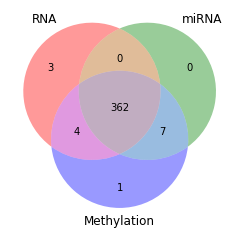

In [7]:
omics = load_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, cancer_type=CANCER_TYPE, norm=True)

In [8]:
X_train, X_test = train_test_split(omics, test_size = .2, random_state = 21, shuffle=True)

## **Auto-Encoder**

* **Model compile & Fit**

In [9]:
encoder = run_ae(X_train=X_train, X_test=X_test, model_path=MODEL_PATH, 
       tensorboard_path=TENSORBOARD_PATH, 
       cancer_type=CANCER_TYPE, file_name=FILE_NAME)

2022-01-18 10:48:54.257151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 10:48:54.258113: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-18 10:48:54.259528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-01-18 10:48:54.259570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-18 10:48:54.259618: I tensorflow/stream_executor/platform/default/dso_loa

INFO:tensorflow:Assets written to: /home/km/gitworking/Multi-omics-intergration/models/AE_LIHC_20220118-104813/assets


## **Feature Selection**

In [10]:
omic_encoded = pd.DataFrame(encoder.predict(omics))
column_name = ["Feature" + str(index) for index in range(1, len(omic_encoded.columns) + 1)]
omic_encoded.columns = column_name

omic_encoded['sample'] = omics.index.to_list()
omic_encoded.set_index('sample', inplace=True)

* **sample phenotype**

In [148]:
pheno = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp", 
                    sep = "\t", usecols=['sample', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time'])

# encoded pheno
omic_encoded_pheno = pd.merge(left=omic_encoded, right=pheno, how="inner", on="sample")
omic_encoded_pheno.set_index('sample', inplace=True)

* **Invoke R - log rank test**

In [12]:
# r invoke log rank test
omic_encoded_fc = omic_encoded[log_test(omic_encoded_pheno)]

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: ggpubr

R[write to console]: 
Attaching package: ‘survminer’


R[write to console]: The following object is masked from ‘package:survival’:

    myeloma




## **Sample Clustering**

In [13]:
# K-Mean Clustering
# invoke r
nb_result = nb_cluster(omic_encoded_fc)
nb_result_K = 2 if int(np.mean(nb_result.iloc[0, :].to_list())) == 3 else int(np.mean(nb_result.iloc[0, :].to_list()))

# k-mean clustering
kmeans = KMeans(n_clusters = nb_result_K, random_state = 31, max_iter = 1000).fit_predict(omic_encoded_fc)

ae_groups = pd.DataFrame(kmeans, columns = ['group'])
ae_groups['sample'] = omic_encoded_fc.index.to_list()
ae_groups.set_index('sample', inplace=True)
ae_groups.to_csv(GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt", sep="\t")

******************************************************************* 
* Among all indices:                                                
* 11 proposed 2 as the best number of clusters 
* 9 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 5 as the best number of clusters 
* 2 proposed 9 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


* **Survival Analysis - logranktest**

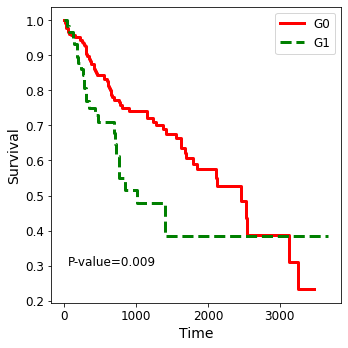

In [136]:
log_pvalue = log_rank_test(df=ae_groups_pheno, png_path=PNG_PATH, file_name=FILE_NAME)

* **Survival Analysis - C-index(Cox-PH)**

In [ ]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

cox = CoxPHFitter()

#fitting
cox.fit(ae_groups_pheno, duration_col='time', event_col='event', show_progress=True)
cox.print_summary()
cox.plot()

#cross-validation
cox_cv_result = k_fold_cross_validation(cox, data, duration_col='time', event_col='event', k=5)
print('C-index(cross-validation) = ', np.mean(cox_cv_result))

## **Select top N Feature**

* **Preprocessed Data Load**

In [184]:
# data_type = ["rna", "mirna", "mt"]
feature_result = dict()

# load preprocess data
omics_preprocess = load_preprocess_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, 
                                     cancer_type=CANCER_TYPE, norm=True, 
                                     group_path=GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt")

In [181]:
omics_preprocess["rna"]

,group,RP11-16E12.2_RNA,RP11-181G12.2_RNA,CPHL1P_RNA,TCOF1_RNA,NSRP1_RNA,RP5-1000K24.2_RNA,SPPL3_RNA,AF001548.5_RNA,OPA3_RNA,...,NFIA_RNA,SELO_RNA,SELK_RNA,SELE_RNA,SLC7A11_RNA,RP11-390F4.3_RNA,GNGT2_RNA,SELT_RNA,NFIX_RNA,SELP_RNA
TCGA-CC-A3MA-01,0,-0.725191,0.799089,-1.263716,1.376435,1.582449,0.998086,-0.641055,1.143305,-0.356267,...,0.510373,-1.611367,-2.034125,-0.617997,-0.189555,-0.279951,0.263964,-0.430188,2.036395,-0.172236
TCGA-DD-AAW0-01,0,-1.110009,-1.176991,0.070469,-0.359322,0.148030,0.750367,-1.128630,0.126448,-0.133451,...,0.491165,-0.217709,-0.789163,0.837167,0.068442,-0.495171,-0.216929,0.609818,-0.446471,1.390014
TCGA-DD-AACA-01,0,-0.622127,-1.635153,-0.904687,0.166838,1.434444,0.133057,-1.303795,-0.266374,-0.841616,...,0.861565,-0.022836,-1.171911,0.191202,-0.125708,0.610237,-1.135676,0.394949,2.429754,-1.165896
TCGA-K7-AAU7-01,1,0.432424,1.883436,2.166038,0.522327,0.913547,0.709817,1.623592,0.628168,0.888443,...,-0.178257,-2.275336,-0.323514,1.178642,1.482436,0.584401,0.258895,-0.005846,-0.555654,1.051563
TCGA-RC-A7SH-01,0,0.979930,0.990395,1.417928,0.323362,-1.219375,-1.946703,1.610665,2.109634,1.145875,...,-0.696742,1.028950,0.663233,-0.985516,-0.207683,0.841962,-0.860116,-1.235947,-0.755017,-0.497836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-2Y-A9H8-01,0,-0.168987,2.105224,0.409776,-0.351947,-0.938370,-0.062511,-0.415689,-0.747970,0.024871,...,-1.139760,0.270439,-1.470142,-1.476574,-0.886426,-0.058869,0.521276,-1.906554,-2.094092,0.091369
TCGA-2Y-A9GT-01,0,0.146764,1.718965,-0.683016,-1.444452,-1.120910,1.238292,-0.400607,0.711367,0.438438,...,0.922286,0.952375,0.348493,0.519703,-1.334924,0.386858,0.704030,0.297571,0.831303,0.678826
TCGA-DD-A73C-01,0,-1.674724,-0.152018,-0.538320,-1.312762,0.326665,-1.327073,-0.369366,-1.148283,0.592752,...,0.477658,1.031241,-0.237561,0.409816,-1.445213,0.809421,0.028586,0.908820,1.091323,0.928448
TCGA-2Y-A9H2-01,0,-0.272842,0.672206,-0.278979,1.064291,1.792535,0.993998,-0.740595,0.503762,1.308205,...,-0.606528,-0.512551,-2.199570,-0.298016,0.251604,-0.349956,0.820337,0.062343,0.189839,-0.232175


* **Select N Feature**

In [ ]:
for d_type in data_type:
    print(d_type)
    
    tmp = list()
    df = omics_preprocess[d_type]
    y = df.pop('group')
    X = df
    
    # anova
    tmp.append(Feature_selection(y, X, "anova", univariate=True))
    
    # randomforest
    tmp.append(Feature_selection(y, X, "rf", univariate=False))
        
    feature_result[d_type] = tmp

* **Feature intersection**

In [ ]:
intersect_feature = set(anovar_feature[0].iloc[:, 1]) & set(rf_feature[0].iloc[:, 0])